In [30]:
import numpy as np
import seaborn
import torch
from einops import rearrange
from torchmetrics import ConfusionMatrix
from torchmetrics.classification import BinaryAccuracy
from tqdm import tqdm

from project.pipeline.balance_data import balance_data_indices_reduction
from project.pipeline.classic_tokenizers import get_bert_tokenizer
from project.pipeline.data_loader import DataLoader
from project.task_a.train_sexist_bert_pretrained import build_model

In [31]:
data_loader = DataLoader()

In [32]:
# get tokenizer
tokenizer = get_bert_tokenizer()

In [33]:
model = build_model(model_path="../trained_agents/sexist_bert_pretrained_a.pt").cuda()
model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [34]:
predictions = []

for batch in tqdm(data_loader):
    # extract text
    # get input
    inputs = list(batch["text"].values)
    inputs = tokenizer(inputs, padding=True, truncation=True, return_tensors="pt")
    inputs.to("cuda")

    # use the model
    outputs = model(**inputs)[0]
    outputs = torch.sigmoid(outputs)
    outputs = rearrange(outputs, "b 1 -> b")
    predictions.append(outputs.detach().cpu().numpy())

100%|██████████| 3500/3500 [00:42<00:00, 81.65it/s]


In [35]:
predictions = np.concatenate(predictions)

In [36]:
df = data_loader.df
balanced_df_indices = balance_data_indices_reduction(df['label_sexist'])

In [37]:
target = df['label_sexist']
target = torch.tensor(np.array([entry != "not sexist" for entry in target]))
predictions = torch.tensor(predictions)

In [38]:
accuracy_metric = BinaryAccuracy()
confusion_matrix_metric = ConfusionMatrix(num_classes=2)
labels = ["not sexist", "sexist"]

Accuracy on whole dataset: 0.9762856960296631


<AxesSubplot: >

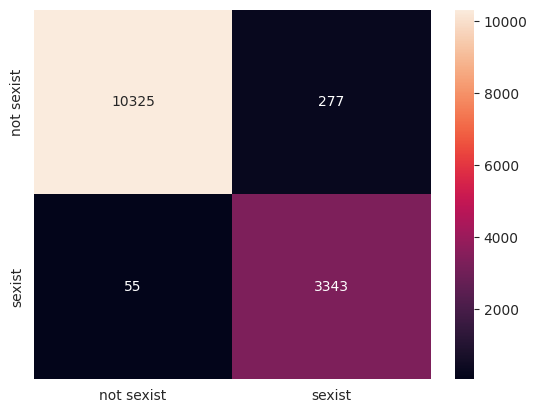

In [39]:
acc = accuracy_metric(predictions, target)
mat = confusion_matrix_metric(predictions, target)
print(f"Accuracy on whole dataset: {acc}")
seaborn.heatmap(mat, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)

Accuracy on balanced dataset: 0.981753945350647


<AxesSubplot: >

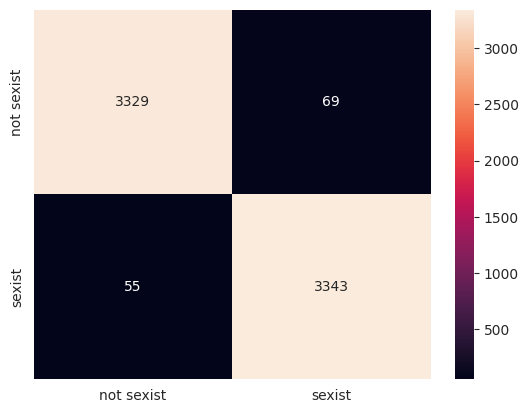

In [40]:
acc = accuracy_metric(predictions[balanced_df_indices], target[balanced_df_indices])
mat = confusion_matrix_metric(predictions[balanced_df_indices], target[balanced_df_indices])
print(f"Accuracy on balanced dataset: {acc}")
seaborn.heatmap(mat, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)